# Dask on an AWS EC2 Cluster

We're going to use [Dask Cloud Provider](https://cloudprovider.dask.org/en/latest/) to launch Dask Clusters on AWS EC2 instances, which we can then control locally. Dask Cloud Provider can be installed locally via:

```bash
pip install dask-cloudprovider[aws]
```

In the cell that follows, Dask Cloud Provider will automatically launch an EC2 cluster on our behalf -- consisting in this case of one scheduler and 4 worker instances. Note that you will need your AWS credentials to be up-to-date in order for this to work (and located in directory indicated in the `get_aws_credentials` function).

In [2]:
from dask_cloudprovider.aws import EC2Cluster 
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version

def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

# Pass in AWS Credentials + any extra packages you would like to install on cluster via `pip`
env_vars = get_aws_credentials()
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs"

# Select software installed on scheduler + worker instances based on client Python + Dask versions
# versions need to match across client, scheduler, worker -- slight mismatches are OK, though
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0]
dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}"
print('Docker Image: ', dask_docker_tag)

# launch a cluster of 5 r5.large instances (10 vCPUs):
# 1 scheduler
# 4 workers (2 threads + 16 GB RAM each)
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=4,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

Docker Image:  daskdev/dask:2023.11.0-py3.9
Creating scheduler instance
Created instance i-090b629e1d6f31276 as dask-38944510-scheduler
Waiting for scheduler to run at 44.202.49.244:8786


Once our cluster is set up, we can connect to it via `dask.distributed`'s `Client` class (which will also give us a link to our interactive dashboard for monitoring our cluster):

In [3]:
client = Client(cluster)
client # note that slight mismatches between client, scheduler, and worker software are fine

/home/jclindaniel/anaconda3/envs/macs301x3/lib/python3.9/site-packages/distributed/client.py:1391: VersionMismatchWarning: Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | Client         | Scheduler      | Workers        |
+-------------+----------------+----------------+----------------+
| cloudpickle | 2.2.1          | 3.0.0          | 3.0.0          |
| msgpack     | 1.0.3          | 1.0.6          | 1.0.6          |
| numpy       | 1.26.4         | 1.26.0         | 1.26.0         |
| pandas      | 2.1.4          | 2.1.2          | 2.1.2          |
| python      | 3.9.19.final.0 | 3.9.18.final.0 | 3.9.18.final.0 |
+-------------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


<Client: 'tcp://172.31.84.123:8786' processes=4 threads=8, memory=61.30 GiB>

Then, we can write code locally that executes on our remote cluster. To start, let's do some simple Dask array operations to demonstrate how arrays and array operations are split up into equal chunks across our 4 workers:

In [4]:
import dask.array as da

n = len(client.scheduler_info()['workers'])
a = da.ones(100, chunks=int(100/n))
a

dask.array<ones_like, shape=(100,), dtype=float64, chunksize=(25,), chunktype=numpy.ndarray>

In [5]:
a.sum() \
 .compute()

100.0

In [6]:
x = da.random.random((10000, 10000), chunks=(1000, 1000))
y = x + x.T
y.mean().compute()

0.9999878101801504

We can also interact with large data sources in S3 via Dask DataFrames, using a lot of the familiar methods we employ in smaller scale applications in Pandas. Here, we read in the NYC Taxi data from 2015 and perform a few simple operations. If you take a look at the Dask task graph while this is running, you can see that our groupby and sum operations are being performed in parallel by our workers.

In [7]:
import dask.dataframe as dd

df = dd.read_parquet('s3://nyc-tlc/trip data/yellow_tripdata_2015*.parquet',
                     engine='pyarrow').persist()

In [8]:
df.describe() \
  .compute()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.460392e+08,146039231,146039231,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08,1.460392e+08
min,1.000000e+00,1970-01-17 10:27:50.400000,1969-12-06 10:23:31.200000,0.000000e+00,-4.084012e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-4.960000e+02,-7.900000e+01,-5.000000e-01,-4.400000e+02,-9.900000e+01,-3.000000e-01,-4.963000e+02
25%,1.000000e+00,1970-01-17 12:26:39.112000,1970-01-17 12:59:39.305000,1.000000e+00,1.050000e+00,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.800000e+00
50%,2.000000e+00,1970-01-17 14:26:31.569000,1970-01-17 15:43:57.521000,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.000000e+01,0.000000e+00,5.000000e-01,1.250000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,1970-01-17 16:50:08.941000,1970-01-17 18:13:54.352000,2.000000e+00,3.300000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.360000e+00,0.000000e+00,3.000000e-01,1.835000e+01
max,2.000000e+00,1970-01-17 19:13:26.399000,1970-04-14 14:21:35.798000,9.000000e+00,5.901661e+07,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,8.259986e+05,6.524200e+02,9.100000e+01,3.950589e+06,1.901400e+03,7.000000e-01,3.950612e+06
mean,1.524660e+00,<NA>,<NA>,1.680858e+00,1.184584e+01,1.041786e+00,1.620416e+02,1.600179e+02,1.378856e+00,1.293904e+01,3.142529e-01,4.976088e-01,1.729140e+00,3.077635e-01,2.983276e-01,1.609726e+01
std,4.993915e-01,<NA>,<NA>,1.333530e+00,1.093597e+04,6.533164e-01,6.704974e+01,7.066191e+01,4.991914e-01,1.243789e+02,4.529671e-01,4.924381e-02,3.269192e+02,1.646136e+00,2.333346e-02,3.569951e+02


In [9]:
distance_by_passenger_count = df[['trip_distance', 'passenger_count']].groupby('passenger_count') \
                                                                      .sum()

# returns Pandas DataFrame
distance_by_passenger_count = distance_by_passenger_count.compute()
distance_by_passenger_count

,trip_distance
passenger_count,
0,9.299311e+04
1,1.411217e+09
2,2.468116e+08
3,9.938326e+06
4,2.230118e+07
5,2.433972e+07
6,1.525381e+07
7,7.894300e+02
8,6.998000e+02


We can also plot and explore our data using standard Matplotlib plotting functionality:

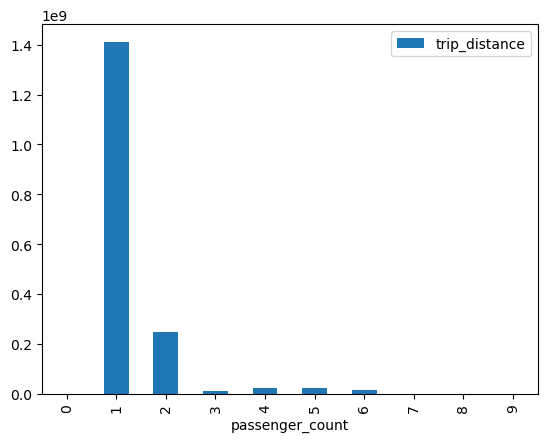

In [10]:
import matplotlib.pyplot as plt

distance_by_passenger_count.plot(kind="bar");

As you do work on a Dask cluster, sometimes you'll notice that you do not need all of the workers you currently have enlisted to do work (and are paying for resources you don't need!). In this case, note that you can scale down your cluster size using the `scale` method. Let's scale down the number of workers in our cluster to 3:

In [11]:
cluster.scale(3)

Terminated dask-38944510-worker-a55835b2 (i-0d1c1d820d8b606c4)


Perhaps more commonly, though, you realize that you don't have enough (compute and/or memory) resources and need to scale out the number of workers in your cluster. You can accomplish this via `scale` as well (just note that we have vCPU and concurrent EC2 instance limits in AWS Academy, so don't scale beyond the resources you have available -- a maximum of 9 total instances and 32 vCPUs). Let's scale back up to 4 worker instances:

In [12]:
# note that it will take several minutes for the new worker to be registered
cluster.scale(4)

Creating worker instance


Created instance i-0c126f8c865e75edb as dask-38944510-worker-e86aa389


Finally, when you're finished with your cluster, be sure to terminate all of your EC2 instances. We can do this via the `close` method (or you can manually go into the EC2 menu in the AWS Console and shut down your instances):

In [13]:
cluster.close()

Terminated dask-38944510-worker-e86aa389 (i-0c126f8c865e75edb)
Terminated dask-38944510-worker-1e88022f (i-0c4746ce6da982ada)
Terminated dask-38944510-worker-8986a0ce (i-0497aa0e58799b235)
Terminated dask-38944510-worker-543e053f (i-0438495cc40b96a58)
Terminated dask-38944510-scheduler (i-090b629e1d6f31276)
